<img style="float: right; margin: 5px 5px 20px 20px;" src="https://upload.wikimedia.org/wikipedia/commons/d/db/Logo_ITESO_normal.jpg" width="100px" height="75px"/>

# 002 Pairs Trading

### Microstructures and trading systems

> **Evelin Ramirez, Pedro Gael Rayas**

## Overview



### Introduction


### **Methodology**

### Code Implementation


## Results

1. **Price Distribution**:
   - The price distribution follows a Weibull distribution, as shown in the histogram.
   - The spot price (`P0 = 51`) is marked with a green dashed line.
   - The optimal bid and ask prices are marked with blue and orange dashed lines, respectively.

2. **Revenue vs. Spread**:
   - The plot shows the relationship between the spread and the expected revenue from liquidity providers and informed traders.
   - The expected revenue decreases as the spread increases, reflecting the trade-off between revenue and market participation.

3. **Optimal Bid-Ask Prices**:
   - The optimal bid price is 46.32
   - The optimal ask price is 54.51
   - The expected revenue at these prices is 0.0504
  


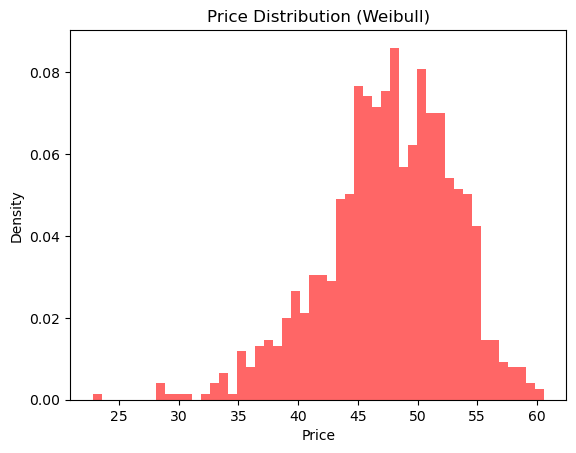

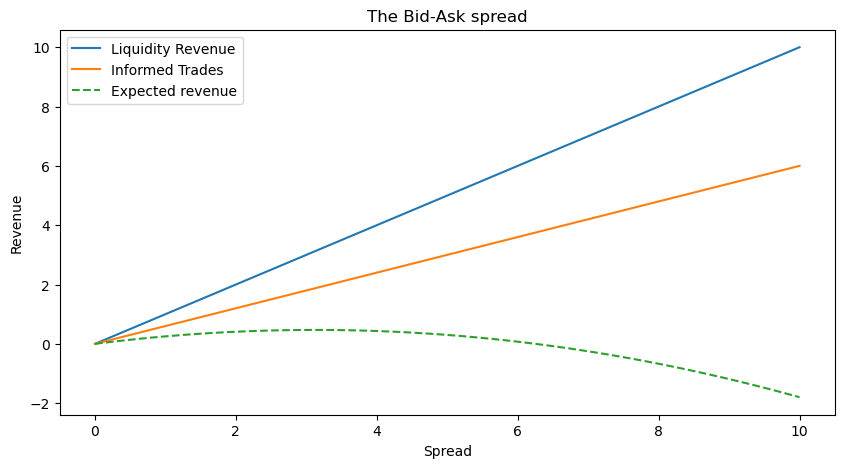

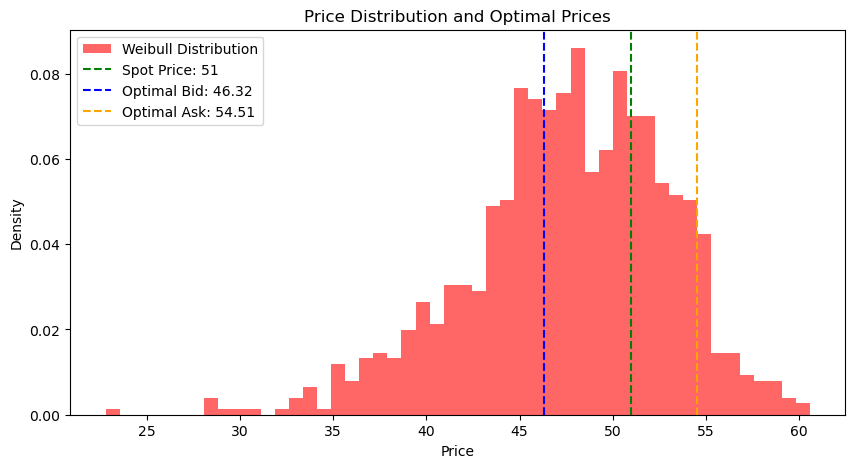

The expected revenue is 0.0504 with a optimal bid price of 46.32 and an optimal ask price of 54.51


In [44]:
%run main.py

## Conclusions


1. **Existence of Spread**:
   - Even in the absence of transaction costs, a bid-ask spread exists due to the presence of informed traders. This aligns with Copeland & Galai's model.

2. **Optimal Pricing**:
   - The market maker can maximize revenue by setting bid and ask prices based on the probability of informed trading and the underlying price distribution.

3. **Trade-offs**:
   - A wider spread increases revenue per trade but reduces the number of trades due to decreased market participation. The optimal spread balances these factors.
  
---

This project provides a foundational understanding of bid-ask spreads and their optimization in financial markets. The insights gained can be applied to real-world market-making strategies.

## Github

HTTPS: https://github.com/elpedrogael/001_Microstructure_Project.git

SSH: git@github.com:elpedrogael/001_Microstructure_Project.git